In [4]:
import pandas as pd

# Load CSVs
sales = pd.read_csv('datasets/sales_data.csv', parse_dates=['date'])
products = pd.read_csv('datasets/products.csv')
customers = pd.read_csv('datasets/customers.csv')
external = pd.read_csv('datasets/external_factors.csv', parse_dates=['date'])

# Inspect
print("Sales data shape:", sales.shape)
print(sales.head())
print(products.head())
print(customers.head())
print(external.head())


Sales data shape: (100000, 10)
        date product_id      product_name       category material_type  \
0 2020-01-01      P0097  Jacket/Hoodie 12  Jacket/Hoodie     Polyester   
1 2020-01-01      P0049    Formal Shirt 4   Formal Shirt         Linen   
2 2020-01-01      P0018        T-Shirt 18        T-Shirt        Cotton   
3 2020-01-01      P0091   Jacket/Hoodie 6  Jacket/Hoodie     Polyester   
4 2020-01-01      P0047    Formal Shirt 2   Formal Shirt         Linen   

  customer_id customer_location  units_sold  price_per_unit_usd  \
0       C0060           Chennai         166               35.45   
1       C0025           Chennai         192               16.12   
2       C0092           Chennai          78               10.08   
3       C0079           Bangkok         274               27.00   
4       C0007           Bangkok          10               20.73   

   discount_percent  
0                 0  
1                10  
2                 0  
3                 0  
4          

Merge External Factors

In [5]:
sales = sales.merge(
    external, 
    left_on=['date','customer_location'], 
    right_on=['date','location'], 
    how='left'
)
sales.drop(columns=['location'], inplace=True)


Merge Product Info

In [6]:
sales = sales.merge(products, on='product_id', how='left')

Merge Customer Info (optional)

In [7]:
sales = sales.merge(customers, on='customer_id', how='left')

In [8]:
sales.head()

,date,product_id,product_name_x,category_x,material_type_x,customer_id,customer_location,units_sold,price_per_unit_usd,discount_percent,...,inflation_index,product_name_y,category_y,material_type_y,material_per_unit_kg,base_cost_usd,suggested_price_usd,customer_name,business_type,location
0,2020-01-01,P0097,Jacket/Hoodie 12,Jacket/Hoodie,Polyester,C0060,Chennai,166,35.45,0,...,99.75,Jacket/Hoodie 12,Jacket/Hoodie,Polyester,0.60,20.10,55.32,Elite Fabrics 60,ExportAgent,Chennai
1,2020-01-01,P0049,Formal Shirt 4,Formal Shirt,Linen,C0025,Chennai,192,16.12,10,...,99.75,Formal Shirt 4,Formal Shirt,Linen,0.35,10.02,26.55,Metro Exports 25,Boutique,Chennai
2,2020-01-01,P0018,T-Shirt 18,T-Shirt,Cotton,C0092,Chennai,78,10.08,0,...,99.75,T-Shirt 18,T-Shirt,Cotton,0.25,5.52,16.08,Global Exports 92,OnlineDistributor,Singapore
3,2020-01-01,P0091,Jacket/Hoodie 6,Jacket/Hoodie,Polyester,C0079,Bangkok,274,27.00,0,...,99.75,Jacket/Hoodie 6,Jacket/Hoodie,Polyester,0.60,15.07,34.54,Moda Retail 79,ExportAgent,Jakarta
4,2020-01-01,P0047,Formal Shirt 2,Formal Shirt,Linen,C0007,Bangkok,10,20.73,0,...,99.75,Formal Shirt 2,Formal Shirt,Linen,0.35,11.31,29.23,Moda Wholesale 7,ExportAgent,Bangkok


Handle Missing Values

In [10]:
# Fill numeric missing values with median
numeric_cols = sales.select_dtypes(include=['float64','int64']).columns
sales[numeric_cols] = sales[numeric_cols].fillna(sales[numeric_cols].median())

# Fill categorical missing values
categorical_cols = sales.select_dtypes(include=['object']).columns
sales[categorical_cols] = sales[categorical_cols].fillna('Unknown')


Clean up columns

In [12]:
# Drop duplicate columns from sales itself (keep the product info from products)
columns_to_drop = [
    'product_name_x', 'category_x', 'material_type_x',
    'avg_temp_c_x','precip_flag_x','holiday_flag_x',
    'usd_to_local_x','inflation_index_x'
]

# Drop only the columns that exist
sales = sales.drop(columns=[c for c in columns_to_drop if c in sales.columns])

# Rename columns to clean names
sales.rename(columns={
    'product_name_y': 'product_name',
    'category_y': 'category',
    'material_type_y': 'material_type',
    'avg_temp_c_y': 'avg_temp_c',
    'precip_flag_y': 'precip_flag',
    'holiday_flag_y': 'holiday_flag',
    'usd_to_local_y': 'usd_to_local',
    'inflation_index_y': 'inflation_index'
}, inplace=True)


Feature Engineering

In [13]:
# Date features
sales['day_of_week'] = sales['date'].dt.dayofweek
sales['month'] = sales['date'].dt.month
sales['year'] = sales['date'].dt.year

# One-hot encode categorical features
sales = pd.get_dummies(sales, columns=['category','material_type'])


Sales over time

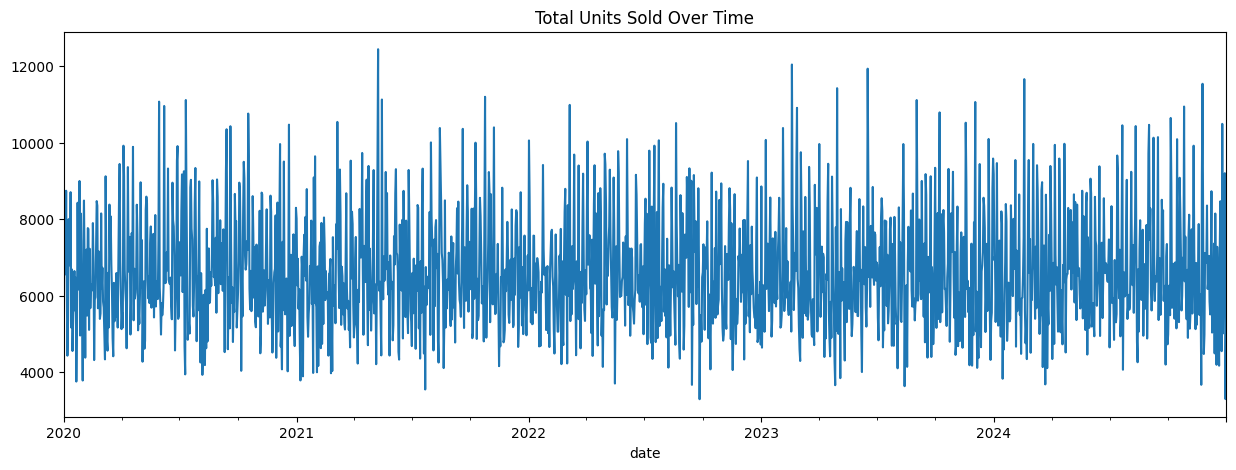

In [14]:
import matplotlib.pyplot as plt

sales.groupby('date')['units_sold'].sum().plot(figsize=(15,5), title='Total Units Sold Over Time')
plt.show()


Units sold by category

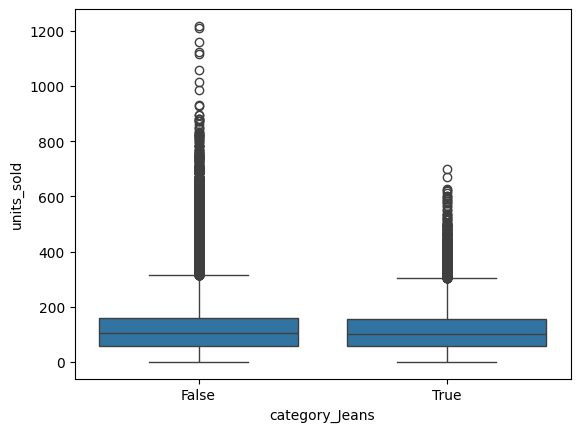

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x='category_Jeans', y='units_sold', data=sales) 
plt.show()


Identify Outliers

In [16]:
import numpy as np

# For units_sold
Q1 = sales['units_sold'].quantile(0.25)
Q3 = sales['units_sold'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Outliers
outliers = sales[(sales['units_sold'] < lower_bound) | (sales['units_sold'] > upper_bound)]
print("Number of outliers:", outliers.shape[0])


Number of outliers: 4123


In [17]:
sales['units_sold'] = np.where(sales['units_sold'] > upper_bound, upper_bound,
                               np.where(sales['units_sold'] < lower_bound, lower_bound, sales['units_sold']))


Decide How to Handle

Keep them – If outliers are realistic (e.g., a huge bulk order), you may keep them, because removing can hurt predictions for large orders.
Cap them (Winsorization) – Limit extreme values to a threshold:

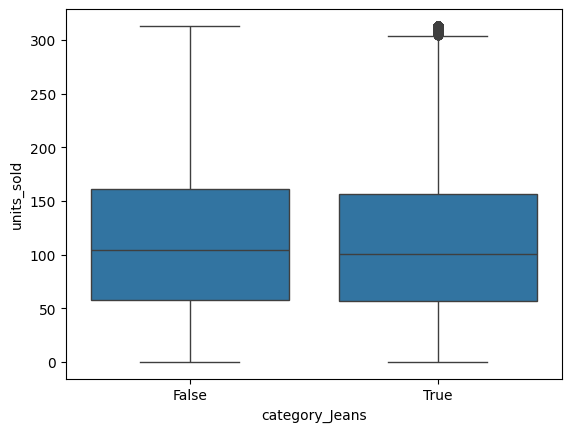

In [18]:
sns.boxplot(x='category_Jeans', y='units_sold', data=sales)
plt.show()


In [19]:
import numpy as np

# For units_sold
Q1 = sales['units_sold'].quantile(0.25)
Q3 = sales['units_sold'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Outliers
outliers = sales[(sales['units_sold'] < lower_bound) | (sales['units_sold'] > upper_bound)]
print("Number of outliers:", outliers.shape[0])

Number of outliers: 0


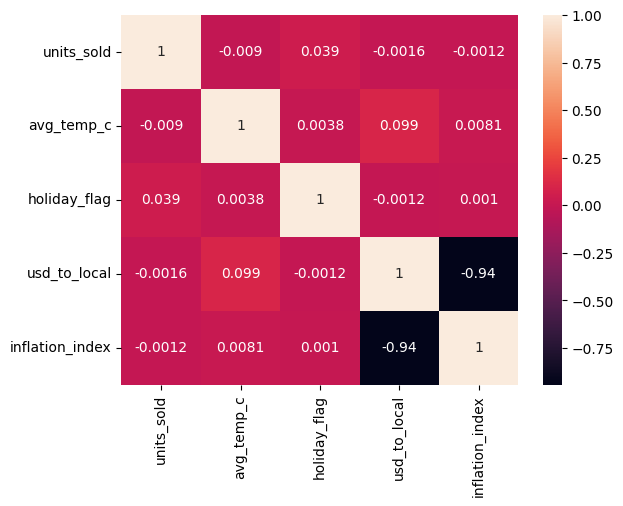

In [20]:
corr = sales[['units_sold','avg_temp_c','holiday_flag','usd_to_local','inflation_index']].corr()
sns.heatmap(corr, annot=True)
plt.show()


In [22]:
# Check which columns are object type (strings)
categorical_cols = X_train.select_dtypes(include=['object']).columns
print(categorical_cols)


NameError: name 'X_train' is not defined

In [23]:
# Identify non-numeric columns in X_train
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)


NameError: name 'X_train' is not defined

In [34]:
# Apply One-Hot Encoding
X_train = pd.get_dummies(X_train, columns=non_numeric_cols)
X_test = pd.get_dummies(X_test, columns=non_numeric_cols)

# Align test set with train set (fill missing columns with 0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


Prepare Train/Test Data

In [29]:
sales = sales.sort_values('date')

# Features (drop target & unnecessary columns)
X = sales.drop(columns=['units_sold','date','product_name','customer_id','customer_name','customer_location'])
y = sales['units_sold']

# Train: 2020-2023, Test: 2024
train_mask = sales['date'] < '2024-01-01'
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]


In [36]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------------
# Step 0: Make sure X_train/X_test are ready
# -----------------------------
# X_train, X_test, y_train, y_test should already exist
# If you have string columns, encode them first
non_numeric_cols = X_train.select_dtypes(include=['object']).columns

# One-hot encoding
X_train = pd.get_dummies(X_train, columns=non_numeric_cols)
X_test = pd.get_dummies(X_test, columns=non_numeric_cols)

# Align columns (ensure test has same columns as train)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# -----------------------------
# Step 1: Define models
# -----------------------------
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
}

# -----------------------------
# Step 2: Train, Predict, Evaluate
# -----------------------------
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Compatible for all versions
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })
    
# -----------------------------
# Step 3: Show results
# -----------------------------
results_df = pd.DataFrame(results)
print(results_df)

# -----------------------------
# Step 4: Identify best model
# -----------------------------
best_model = results_df.loc[results_df['RMSE'].idxmin()]
print("\nBest Model based on RMSE:")
print(best_model)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1250
[LightGBM] [Info] Number of data points in the train set: 79803, number of used features: 136
[LightGBM] [Info] Start training from score 117.160458
              Model        MAE       RMSE        R2
0  LinearRegression  53.353096  66.500314  0.310679
1      RandomForest  54.533183  68.291808  0.273039
2          LightGBM  52.471631  65.829669  0.324513

Best Model based on RMSE:
Model     LightGBM
MAE      52.471631
RMSE     65.829669
R2        0.324513
Name: 2, dtype: object


Save the trained model

In [41]:
import joblib

# Save LightGBM model
best_lgb_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
best_lgb_model.fit(X_train, y_train)

joblib.dump(best_lgb_model, 'demand_predictor_model.pkl')
print("✅ LightGBM model saved as demand_predictor_model.pkl")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1250
[LightGBM] [Info] Number of data points in the train set: 79803, number of used features: 136
[LightGBM] [Info] Start training from score 117.160458
✅ LightGBM model saved as demand_predictor_model.pkl


Save preprocessing information

In [42]:
import pickle

# Save column names for later alignment
with open('columns.pkl', 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)

print("✅ Columns saved for preprocessing alignment")


✅ Columns saved for preprocessing alignment


In [24]:
sales.to_csv("merged_sales_data.csv", index=False)